预测对的结果数目为： 329
预测错的结果数目为： 41
验证集准确率 (Accuracy): 0.8892
验证集精确率 (Precision): 0.8931
验证集召回率 (Recall): 0.8892
验证集 F1 值: 0.8897
验证集 Cohen’s Kappa 系数: 0.8508

分类报告:
                  precision    recall  f1-score   support

            fir       0.82      0.86      0.84       102
           pine       0.96      0.84      0.89        79
         spruce       0.86      0.93      0.89       108
trembling aspen       0.96      0.93      0.94        81

       accuracy                           0.89       370
      macro avg       0.90      0.89      0.89       370
   weighted avg       0.89      0.89      0.89       370



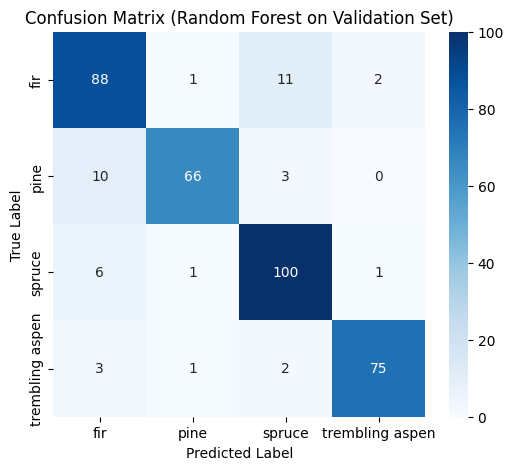


混淆矩阵：
                  fir  pine  spruce  trembling aspen
fir               88     1      11                2
pine              10    66       3                0
spruce             6     1     100                1
trembling aspen    3     1       2               75


In [1]:
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report

# 标签映射
label_mapping = {
    0: 'fir',
    1: 'pine',
    2: 'spruce',
    3: 'trembling aspen'
}

def get_labels(label_dir, image_files):
    labels = []
    for image_file in image_files:
        label_file = os.path.join(label_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        with open(label_file, 'r') as f:
            label_data = f.readlines()
            image_labels = []
            for line in label_data:
                class_id = int(line.split()[0])
                image_labels.append(class_id)
            labels.append(image_labels)
    return labels

def extract_lbp_and_glcm_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    radius = 1
    n_points = 8 * radius
    lbp_image = local_binary_pattern(gray, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_features = [contrast, homogeneity, energy, correlation]

    features = np.hstack([lbp_hist, glcm_features])
    return features

def load_dataset(image_folder, label_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    y_labels = get_labels(label_folder, image_files)
    X_features = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        features = extract_lbp_and_glcm_features(image_path)
        X_features.append(features)
    X = np.array(X_features)
    y = np.array([max(labels) for labels in y_labels])
    return X, y

# 文件夹路径（请修改为你自己的路径）
train_image_folder = '/workspace/sci/RF/370/ptc/train_images'
train_label_folder = '/workspace/sci/RF/370/ptc/train_label'

val_image_folder = '/workspace/sci/RF/370/ptc/val_images'
val_label_folder = '/workspace/sci/RF/370/ptc/val_label'

# 加载训练集和验证集
X_train, y_train = load_dataset(train_image_folder, train_label_folder)
X_val, y_val = load_dataset(val_image_folder, val_label_folder)

# 训练随机森林
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 在验证集上评估
y_pred = rf.predict(X_val)

# 评估指标
true = np.sum(y_pred == y_val)
false = y_val.shape[0] - true
print('预测对的结果数目为：', true)
print('预测错的结果数目为：', false)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)

print(f'验证集准确率 (Accuracy): {accuracy:.4f}')
print(f'验证集精确率 (Precision): {precision:.4f}')
print(f'验证集召回率 (Recall): {recall:.4f}')
print(f'验证集 F1 值: {f1:.4f}')
print(f'验证集 Cohen’s Kappa 系数: {kappa:.4f}')

# 分类报告
y_val_named = [label_mapping[label] for label in y_val]
y_pred_named = [label_mapping[label] for label in y_pred]
print('\n分类报告:\n', classification_report(y_val_named, y_pred_named))

# 混淆矩阵
cm = confusion_matrix(y_val_named, y_pred_named)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest on Validation Set)')
plt.show()

cm_df = pd.DataFrame(cm, index=list(label_mapping.values()), columns=list(label_mapping.values()))
print("\n混淆矩阵：\n", cm_df)

